In [58]:
import numpy as np
import pandas as pd
import joblib
import re
from collections import Counter
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)

df = pd.read_excel('data/Loyalty_dataset_v4.xlsx', 'Última Poliza', engine='openpyxl')
#df = pd.read_excel('data/Loyalty_dataset_v4.xlsx', 'dataset_v4', engine='openpyxl')

In [59]:
tipo_poliza_map = {
    'BIC': 'OFF Shore',
    'BINS': 'OFF Shore',
}

df['tipo_poliza'] = df.CoverEntity.map(tipo_poliza_map)
df['tipo_poliza'].fillna('ON Shore', inplace=True)
df['tipo_poliza'].unique()

array(['OFF Shore', 'ON Shore'], dtype=object)

In [59]:
import plotly.express as px
corr_mat = df.drop('PH_ContactBaseID', axis=1).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
fig = px.imshow(corr_mat[corr_mat > .8])
fig.show()

In [60]:
# corr(PlanKey, CoverProduct) = 0.84
# corr(RateClassL0, PremiumCalculator) = 0.81
# corr(RateIncreasePortfolio, RateIncrease) = 0.867

In [60]:
# Remove not useful variables
df = df.drop(["Renewal", 'CoverageFromDate', 'CoverageThruDate', 'PolicyYear', 'Orden', 
                'GuarianAge', 'UnknownCount', 'Unknown1', 'Unknown2', 'Unknown3', 
                'Unknown4', 'Unknown5', 'Unknown6', 'Unknown7', 'Unknown8', 'Unknown9', 'LapseMid'], axis=1)
df

,PH_ContactBaseID,PolicyMonth,BillingFreq,PlanKey,RegionKey,CoverEntity,CoverProduct,CoverPlan,ProductGroup,RiskCountry,RateClassL0,RateClassL1,Duration,Members,FamilyStructure,OwnerAge,SpouseAge,DependentsCountLT23,DependentsCountAT23,LapseFull,PremiumCalculator,PremiumIn,PremiumOut,PremiumOutConstant,RenewedAT23,flagAlcoholMisuse,flagAsthma,flagAtrialFibrillation,flagCancerLymphoma,flagCancerMetastatic,flagCancerNonMetastatic,flagChronicHeartFailure,flagChronicKidneyDisease,flagChronicPain,flagChronicPulmonaryDisease,flagChronicViralHepatitis,flagCirrhosis,flagDementia,flagDepression,flagDiabetes,flagEpilepsy,flagHypertension,flagHypothyroidism,flagInflammatoryBowel,flagIrritableBowel,flagMultipleSclerosis,flagMyocardialInfarction,flagParkinsons,flagPepticUlcer,flagPeripheralVascular,flagPsoriasis,flagRheumatoidArthritis,flagSchizophrenia,flagSevereConstipation,flagStroke,RateIncrease,RateIncreasePortfolio,RateIncreaseAge,PaidClaims,IncurredClaims,CountClaims,DenialsL12,DeadEndFlag,TransferBupaMexico,TransferBupaEcuador,TransferBupaDR,TransferBupaBolivia,TransferBupaPanama,TransferBupaGuatemala,SuccessorsFoundDiffNumber,tipo_poliza
0,251795,2,Annual,AMP_E4V,AMP_Region Venezuela,BIC,Amedex Worldwide,Plan E,Mid,Venezuela,Amedex Worldwide,Venezuela,20,2,Married,62,58.0,0,0,0,Normal,9386,10051,10051,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.070850,0.070850,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
1,251797,2,Annual,AMP_E4V,AMP_Region Venezuela,BIC,Amedex Worldwide,Plan E,Mid,Venezuela,Amedex Worldwide,Venezuela,19,1,Single,32,NaN,0,0,1,Normal,1871,2121,2121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.133618,0.133618,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
2,251798,2,Annual,AMP_E4V,AMP_Region Venezuela,BIC,Amedex Worldwide,Plan E,Mid,Venezuela,Amedex Worldwide,Venezuela,19,1,Single,29,NaN,0,0,1,Normal,1651,2121,1873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.284676,0.134464,0.132408,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
3,251806,1,Semi-Annual,AMP_ET63,AMP_Region 3 Bupa,BIC,Bupa Care Essential,Plan 6,Low,El Salvador,Bupa Care Offshore,Region 3,20,2,Married,57,57.0,0,0,0,Normal,8158,9232,9232,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.131650,0.131650,0.000000,4199.998,4285.712245,29,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
4,251809,1,Semi-Annual,AMP_ET63,AMP_Region 3 Bupa,BIC,Bupa Care Essential,Plan 6,Low,El Salvador,Bupa Care Offshore,Region 3,20,1,Single,25,NaN,0,0,1,Normal,1837,2083,2083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.133914,0.133914,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59577,1284554,2,Quarterly,AMP_AW41,AMP_Region 1 Bupa,BIC,Bupa Care Advantage,Plan 4,Mid,Mexico,Bupa Care Offshore,Region 1,12,1,Single,95,NaN,0,0,0,Normal,46338,50745,50745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.095106,0.095106,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
59578,1286869,2,Semi-Annual,AMP_BGSG4,AMP_Guatemala Company,Bupa Guatemala,Bupa Global Select,Plan 4,Global Props,Guatemala,No Region,No Region,3,1,Single,69,NaN,0,0,0,Normal,9137,11429,10508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.250848,0.150049,0.087648,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,ON Shore
59579,1288285,3,Annual,AMP_CR56,AMP_Region 6 Bupa,BIC,Bupa Care Critical,Plan 5,Critical,Colombia,Bupa Care Offshore,Region 6,4,1,Single,30,NaN,0,0,1,Critical,820,955,955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.164634,0.164634,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
59580,12892

In [61]:
disease_cols = [col for col in df.columns if col.startswith('flag')]

# New features
df['TotalDiseases'] = df[disease_cols].sum(axis=1)
df['Premiun_diff'] = df.PremiumOut - df.PremiumIn

In [62]:
#ON Shore
tipo_poliza = 'ON Shore'
model_df = df.query(f'tipo_poliza == "{tipo_poliza}"')

In [63]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
# One-hot encoding for categorical variables
x1=pd.get_dummies(model_df["BillingFreq"])
model_df = pd.concat([model_df, x1], axis=1)

x2=pd.get_dummies(model_df["ProductGroup"])
#x2.rename(columns={'Critical': 'ProductGroup_Critical'}, inplace= True)
model_df = pd.concat([model_df, x2], axis=1)

x3=pd.get_dummies(model_df["RiskCountry"])
model_df = pd.concat([model_df, x3], axis=1)

x4=pd.get_dummies(model_df["FamilyStructure"])
model_df = pd.concat([model_df, x4], axis=1)

# x5=pd.get_dummies(model_df["PlanKey"])
# model_df = pd.concat([model_df, x5], axis=1)

# x6=pd.get_dummies(model_df["CoverPlan"])
# model_df = pd.concat([model_df, x6], axis=1)

# x7=pd.get_dummies(model_df["RateClassL1"])
# model_df = pd.concat([model_df, x7], axis=1)
# #Remove duplicated columns
# model_df = model_df.loc[:,~model_df.columns.str.replace(' ', '').duplicated()]

# Rename column names with puntuation or symbols
model_df = model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model_df = model_df.select_dtypes(exclude=['object'])
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15964 entries, 8652 to 59578
Data columns (total 80 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PH_ContactBaseID             15964 non-null  int64  
 1   PolicyMonth                  15964 non-null  int64  
 2   Duration                     15964 non-null  int64  
 3   Members                      15964 non-null  int64  
 4   OwnerAge                     15964 non-null  int64  
 5   SpouseAge                    5527 non-null   float64
 6   DependentsCountLT23          15964 non-null  int64  
 7   DependentsCountAT23          15964 non-null  int64  
 8   LapseFull                    15964 non-null  int64  
 9   PremiumIn                    15964 non-null  int64  
 10  PremiumOut                   15964 non-null  int64  
 11  PremiumOutConstant           15964 non-null  int64  
 12  RenewedAT23                  15964 non-null  int64  
 13  flagAlcoholMi

In [64]:
y = model_df['LapseFull']
X = model_df.drop(['LapseFull'], axis=1)
X.fillna(0, inplace=True)

In [114]:
X.shape

(43618, 167)

In [182]:
from sklearn.metrics import normalized_mutual_info_score
nmi = dict()
for col in X.columns:
    nmi[col] = normalized_mutual_info_score(y, X[col])

nmi = sorted(nmi.items(), key=lambda x: x[1], reverse=True)
nmi

/home/andres/miniconda3/envs/ml-env/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning:

Clustering metrics expects discrete values but received binary values for label, and continuous values for target

/home/andres/miniconda3/envs/ml-env/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning:

Clustering metrics expects discrete values but received binary values for label, and continuous values for target

/home/andres/miniconda3/envs/ml-env/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning:

Clustering metrics expects discrete values but received binary values for label, and continuous values for target

/home/andres/miniconda3/envs/ml-env/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning:

Clustering metrics expects discrete values but received binary values for label, and continuous values for target

/home/andres/miniconda3/envs/ml-env/lib/python3.9/site-p

[('DeadEndFlag', 0.22074990463969316),
 ('TransferBupaMexico', 0.119137817120518),
 ('SuccessorsFoundDiffNumber', 0.10572347929000445),
 ('RateIncrease', 0.09908294411037963),
 ('RateIncreaseAge', 0.09454055434189922),
 ('RateIncreasePortfolio', 0.09379558504144744),
 ('IncurredClaims', 0.08585181365453808),
 ('PaidClaims', 0.08567374594717785),
 ('PremiumOut', 0.06528018024658473),
 ('PremiumOutConstant', 0.0643943174651378),
 ('PremiumIn', 0.06146654469704768),
 ('Annual', 0.04756520445385955),
 ('Premiun_diff', 0.027206515617579592),
 ('Quarterly', 0.024524406231082953),
 ('TransferBupaGuatemala', 0.021702605938809773),
 ('SemiAnnual', 0.01998017712812482),
 ('Venezuela', 0.016207688653054553),
 ('Region7', 0.01544371832102899),
 ('Brazil', 0.015287024335199158),
 ('TransferBupaEcuador', 0.013730450062583496),
 ('Mexico', 0.012850880835339912),
 ('Duration', 0.012583224496237557),
 ('TotalDiseases', 0.011972791990852069),
 ('Region5', 0.010620973434827357),
 ('Monthly', 0.0100090468

In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Standardize
X_scaled = StandardScaler().fit_transform(X)

# Create principal components
pca = PCA()
pca_out = pca.fit(X_scaled)

cumvar = np.cumsum(pca_out.explained_variance_ratio_)
px.line(y = cumvar)

In [184]:
# from bioinfokit.visuz import cluster
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
px.bar(x=pc_list,y = pca_out.explained_variance_ratio_)

In [226]:
features = X.columns
pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=y)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [227]:
Counter(y)

Counter({1: 6187, 0: 9777})

In [ ]:
import lightgbm as lgb
train_auc, test_auc = [], []
for random_state in range(42,43):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    print(Counter(y_train))
    print(Counter(y_test))
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 6,
        'learning_rate': 0.1,
        'feature_fraction': 0.66,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'verbose': 2
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=200)

    scorexbg_train = gbm.predict(X_train,num_iteration=gbm.best_iteration)
    scorexbg_test = gbm.predict(X_test,num_iteration=gbm.best_iteration)

    #acc = np.mean(y_test == predxbg_test)
    #balanced_acc = balanced_accuracy_score(y_test, predxbg_test)
    #f1_scr = f1_score(y_test, predxbg_test, average='micro')
    auc_scr = roc_auc_score(y_train, scorexbg_train)
    train_auc.append(auc_scr)

    auc_scr = roc_auc_score(y_test, scorexbg_test)
    test_auc.append(auc_scr)

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, balanced_accuracy_score, f1_score, roc_auc_score, jaccard_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint


train_auc, test_auc = [], []
for random_state in range(42,53):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    # print(Counter(y))
    # print(Counter(y_train))
    # print(Counter(y_test))

    #skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)
    
    if tipo_poliza == 'ON Shore':
        best_xgb = XGBClassifier(
                max_depth=6, n_estimators=150, reg_alpha=1, reg_lambda=1, gamma=0, objective = "binary:logistic", 
                nthread=-1, booster='gbtree', tree_method='hist', num_parallel_tree=4, eta= .1, 
                grow_policy='lossguide', min_child_weight=1, subsample=.6, max_delta_step=1, eval_metric='auc',
                scale_pos_weight=3)
    elif tipo_poliza == 'OFF Shore':
        best_xgb = XGBClassifier(
                max_depth=7, n_estimators=190, reg_alpha=0, reg_lambda=1, gamma=0, objective = "binary:logistic", 
                nthread=-1, booster='gbtree', tree_method='hist', num_parallel_tree=4, eta= .1, 
                grow_policy='lossguide', min_child_weight=3, subsample=.6, max_delta_step=1, eval_metric='auc',
                scale_pos_weight=2, verbosity=0)
    
    best_xgb.fit(X_train, y_train)

    # modelXGB = XGBClassifier(objective = "binary:logistic", nthread=6, booster='gbtree', tree_method='gpu_hist',
    #     num_parallel_tree=4, grow_policy='lossguide', subsample=.6, max_delta_step=1, eval_metric='auc', eta=.1,
    #     scale_pos_weight=sum(y_train == 0)/sum(y_train == 1)
    #     )

    # parameters = {'max_depth': randint(1,8), 
    #             'n_estimators': randint(100,300),
    #             'lambda': randint(1,5),
    #             "gamma" : randint(.1,2), 
    #             'alpha': randint(.1,2),
    #             'min_child_weight': randint(1,5)
    # }

    # clf = RandomizedSearchCV(modelXGB, parameters, cv=skf.split(X_train, y_train), n_iter=50, n_jobs=6, scoring='roc_auc', random_state=42)
    # clf.fit(X_train,y_train)
    # best_xgb = clf.best_estimator_

    scorexbg_train = best_xgb.predict_proba(X_train)[:,1]
    scorexbg_test = best_xgb.predict_proba(X_test)[:,1]
    predxbg_test = best_xgb.predict(X_test)

    #acc = np.mean(y_test == predxbg_test)
    #balanced_acc = balanced_accuracy_score(y_test, predxbg_test)
    #f1_scr = f1_score(y_test, predxbg_test, average='micro')
    auc_scr = roc_auc_score(y_train, scorexbg_train)
    train_auc.append(auc_scr)

    auc_scr = roc_auc_score(y_test, scorexbg_test)
    test_auc.append(auc_scr) 

In [66]:
print(f'mean auc roc: {np.mean(train_auc)}', f'\nstandard deviation auc roc: {np.std(train_auc)}')

mean auc roc: 0.9737692859014797 
standard deviation auc roc: 0.0008175057774559242


In [67]:
print(f'mean auc roc: {np.mean(test_auc)}', f'\nstandard deviation auc roc: {np.std(test_auc)}')

mean auc roc: 0.9078250266774796 
standard deviation auc roc: 0.0031574640012309906


In [32]:
best_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='auc', gamma=0, gpu_id=0,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=1, learning_rate=0.100000001,
              max_delta_step=1, max_depth=7, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=189, n_jobs=6, nthread=6,
              num_parallel_tree=4, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.1204250295159386, ...)>

In [ ]:
#joblib.dump(best_xgb, 'models_new/OFFShore_lapsefull.pkl') 

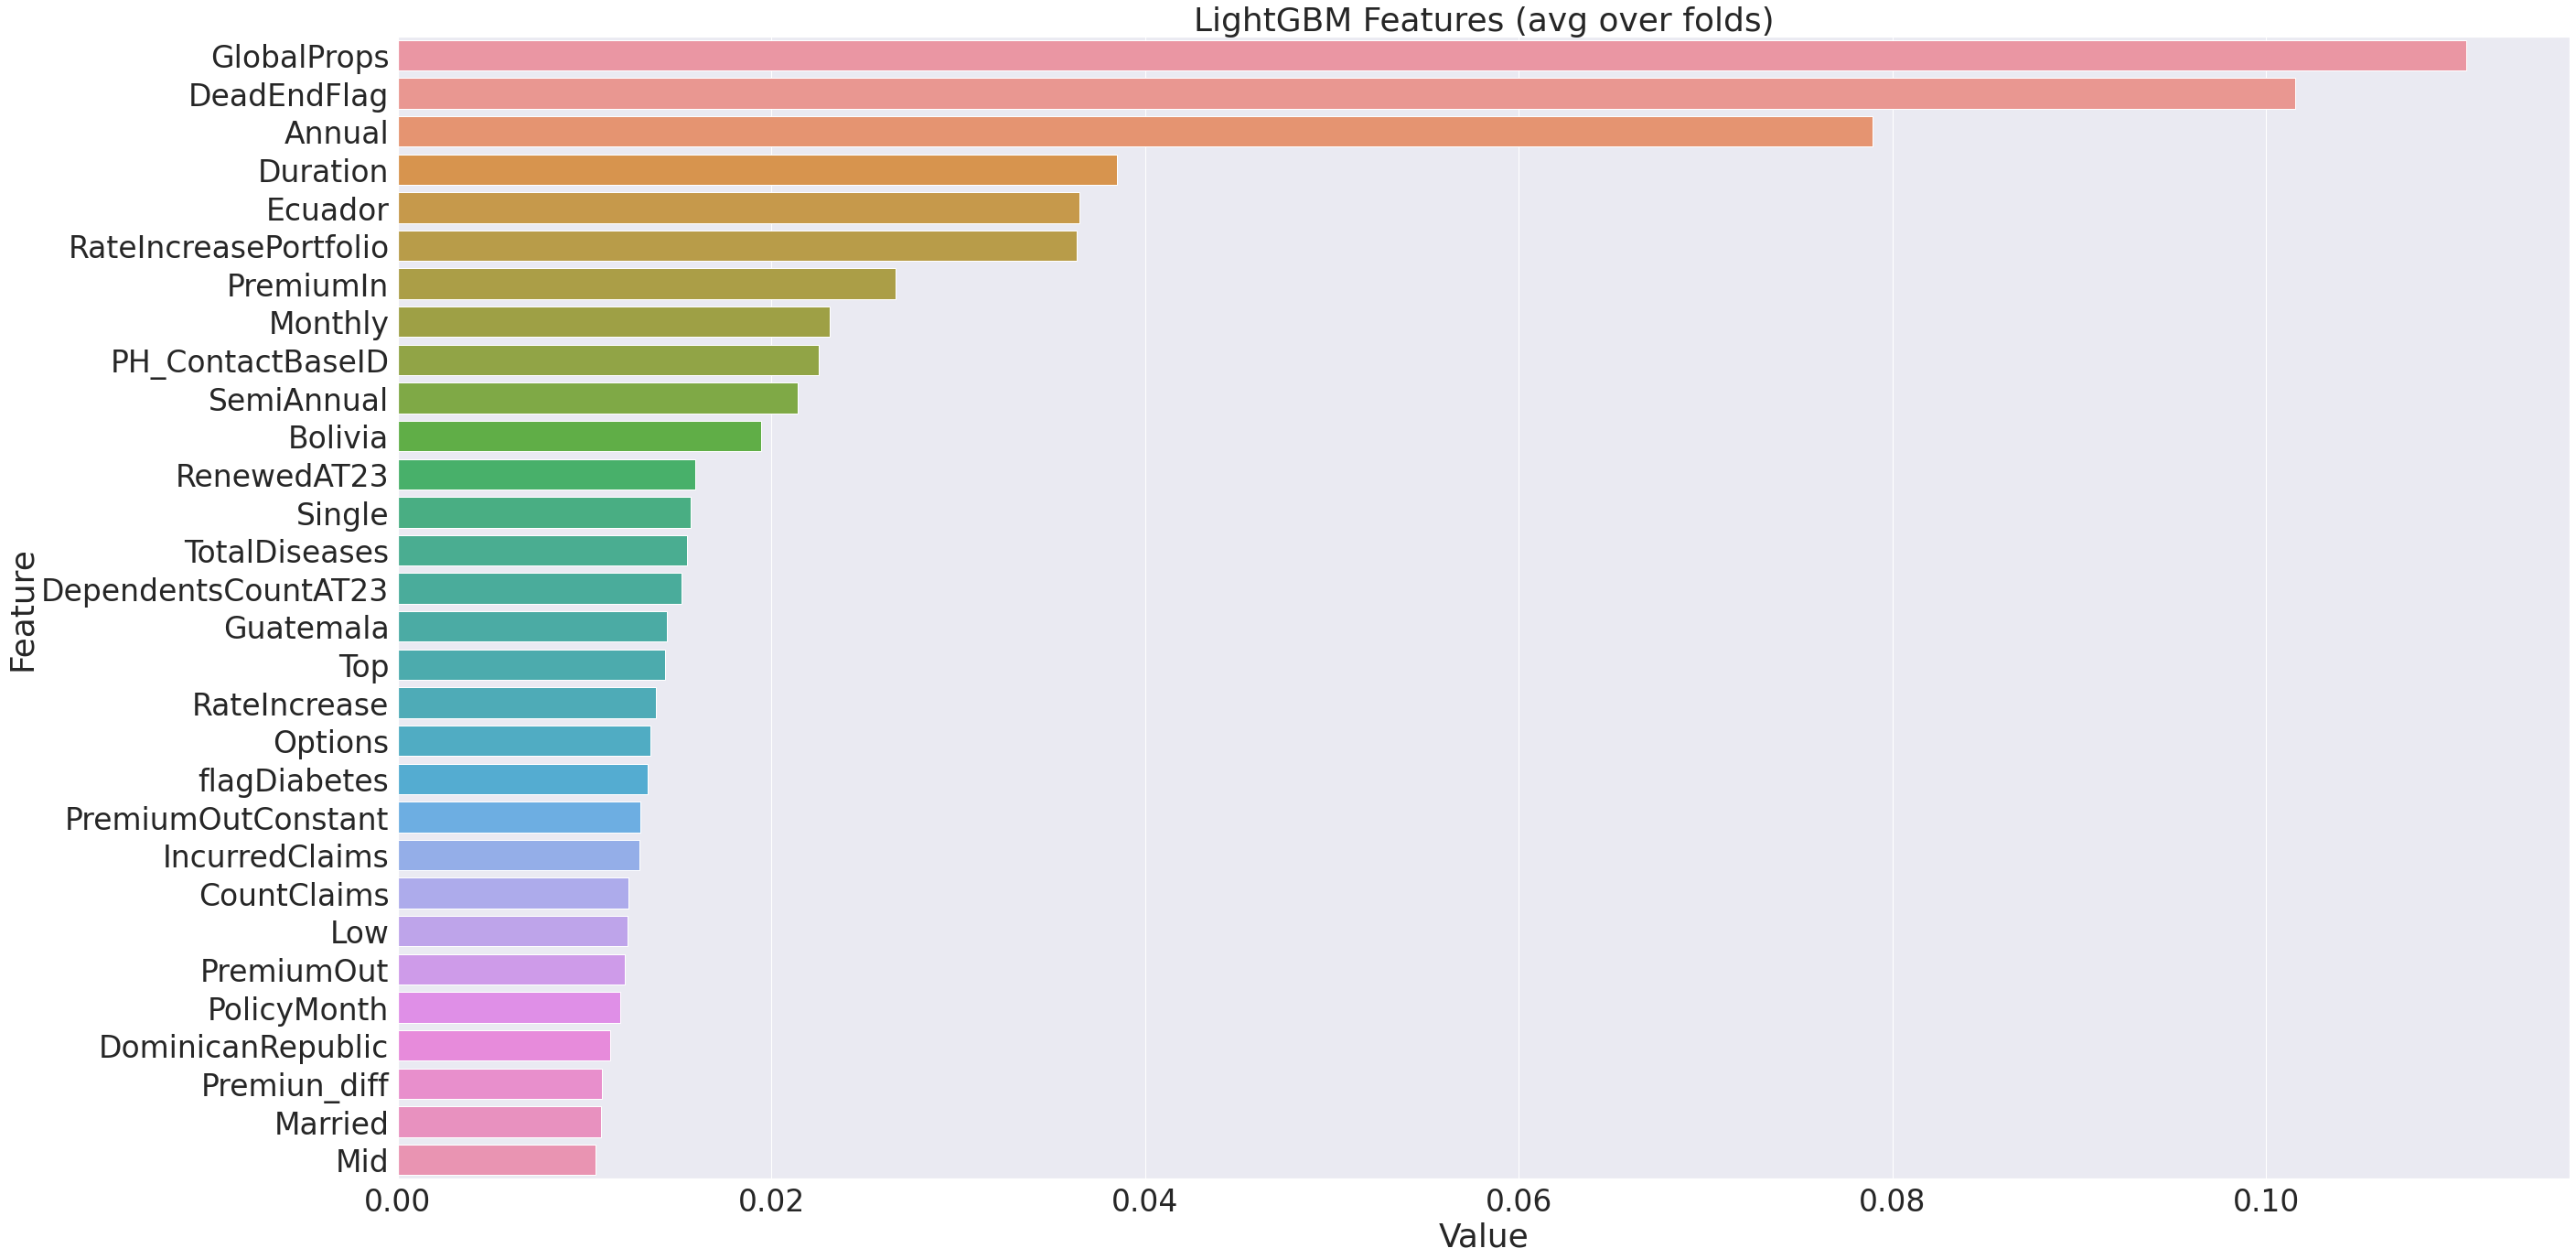

In [17]:
feat_rank = best_xgb.feature_importances_
#feat_rank = gbm.feature_importance()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame({'Value':feat_rank,'Feature':X_train.columns})

plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:30])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-01.png')
plt.show()

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = np.round(cm.astype(float) / cm.sum(axis=0), 2)#[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion sin normalizar')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        #plt.tight_layout()
        plt.ylabel('Prediccion')
        plt.xlabel('Valor observado')

Matriz de confusión para el conjunto de testeo
Matriz de confusion sin normalizar
[[2324  264]
 [ 658 1544]]
Matriz de confusion normalizada
[[0.78 0.15]
 [0.22 0.85]]


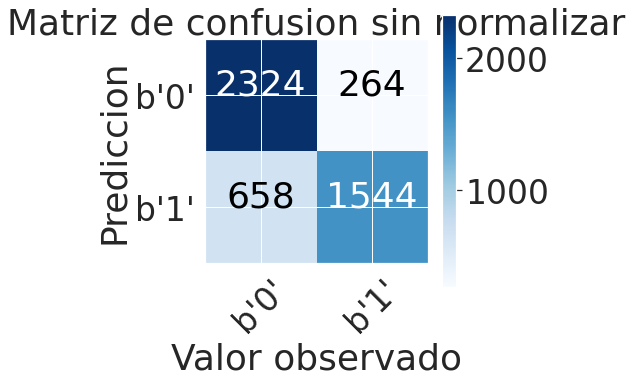

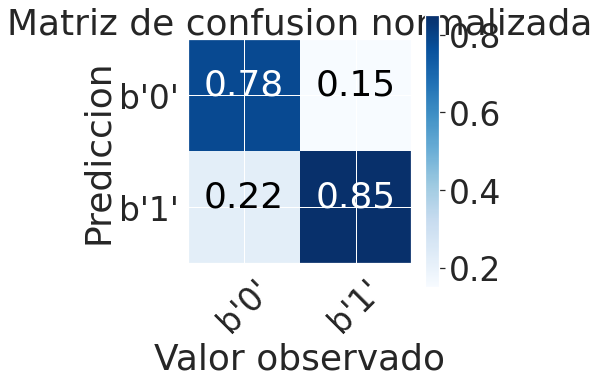

The test accuracy is: 0.8075156576200417
The test balanced accuracy is: 0.8166625119448253
The test F1-score is: 0.8075156576200417
The test ROC_AUC is: 0.9118137104336934
The test Jaccard is: 0.677170868347339
The test logaritmical loss is: 0.3971371192880031


In [53]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = np.array(['0', '1'],  dtype='|S10')

print("Matriz de confusión para el conjunto de testeo")
# Compute Testing confusion matrix
cnf_matrix = confusion_matrix(predxbg_test, y_test)
#np.set_printoptions(precision=2)
# Plot matriz de confusion sin normalizar
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
title='Matriz de confusion sin normalizar')

# Plot matriz de confusion normalizada
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
title='Matriz de confusion normalizada')
plt.show()


from sklearn.metrics import log_loss, balanced_accuracy_score, f1_score, roc_auc_score, jaccard_score
acc = np.mean(y_test == predxbg_test)
balanced_acc = balanced_accuracy_score(y_test, predxbg_test)
f1_scr = f1_score(y_test, predxbg_test, average='micro')
auc_scr = roc_auc_score(y_test, scorexbg_test, average='micro')
jac_scr = jaccard_score(y_test, predxbg_test, average='micro')
logloss = log_loss(y_test, scorexbg_test)

print(f"The test accuracy is: {acc}")
print(f"The test balanced accuracy is: {balanced_acc}")
print(f"The test F1-score is: {f1_scr}")
print(f"The test ROC_AUC is: {auc_scr}")
print(f"The test Jaccard is: {jac_scr}")
print(f"The test logaritmical loss is: {logloss}")